In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(42)

In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000
n_iter = 1000
n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

In [5]:
print(X_train.shape)

(75000,)


In [6]:
y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import svm

In [9]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [10]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [11]:
print(type(X_train_f))
X_train_f_np = X_train_f.todense()
print(type(X_train_f_np))
#y_train = y_train.reshape((y_train.shape[0],1))
print(X_train_f_np.shape)
print(y_train.shape)

<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.matrix'>
(75000, 4946)
(75000,)


In [12]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [13]:
model = gnb.fit(X_train_f_np, y_train)

In [14]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")
X_test_f = feature_pipeline.fit_transform(X_test)
X_test_f_np = X_test_f.todense()

In [15]:
print(X_test_f_np.shape)
print(y_test.shape)

(15000, 5662)
(15000,)


In [16]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [17]:
from sklearn.metrics import accuracy_score

In [18]:

n_trainSamples = [10000,20000,50000,75000] # edited to have size > 949 (best k)

valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:

    # Choose optimum K from GridSearchCV results
    bestModel = GaussianNB()

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    X_train_f_np = X_train_f.todense()
    bestModel.fit(X_train_f_np,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    X_val_f_np = X_val_f.todense()
    preds_val = bestModel.predict(X_val_f_np)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    X_test_f_np = X_test_f.todense()
    preds_test = bestModel.predict(X_test_f_np)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f_np)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    print("------------------------------------")
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 10000
Train Time:4.02 sec
Validation Accuracy: 55.33%
Validation Time:3.51 sec
Test Accuracy: 54.65%
Test Time:3.60 sec
(0.4191913419913412, 0.12466666666666666, 0.49533333333333335)
MRR: 0.4191913419913412
MRR Time:2.14 sec
------------------------------------
SampleSize: 20000
Train Time:7.70 sec
Validation Accuracy: 55.85%
Validation Time:3.20 sec
Test Accuracy: 54.75%
Test Time:3.30 sec
(0.44675613275613324, 0.16, 0.5553333333333333)
MRR: 0.44675613275613324
MRR Time:1.87 sec
------------------------------------
SampleSize: 50000
Train Time:17.71 sec
Validation Accuracy: 57.69%
Validation Time:3.12 sec
Test Accuracy: 56.81%
Test Time:3.17 sec
(0.4546326599326601, 0.14266666666666666, 0.6433333333333333)
MRR: 0.4546326599326601
MRR Time:1.96 sec
------------------------------------
SampleSize: 75000
Train Time:26.27 sec
Validation Accuracy: 58.15%
Validation Time:3.05 sec
Test Accuracy: 57.27%
Test Time:3.20 sec
(0.4506448773448774, 0.124, 0.6606666666666666)
MRR: 0.4506

In [19]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("GNB_Tokens_Accuracy.png")
    #plt.show()

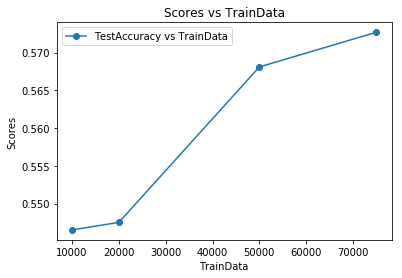

In [20]:
accuracyVisualization()

In [21]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("GNB_Tokens_Mrr.png")
    plt.show()

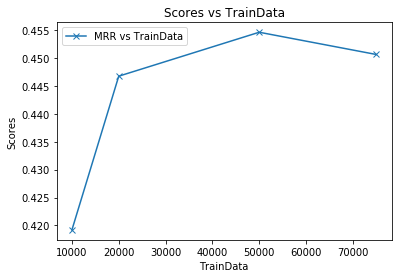

In [22]:
mrrVisualization()

In [23]:
def precisionVisualization():
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,precisionAt1,label='Precision@1 vs TrainData',marker='o')
    ax.plot(n_trainSamples,precisionAt3,label='Precision@3 vs TrainData',marker='x')
    plt.title("Precision Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("GNB_Tokens_Precision.png")
    #plt.show()

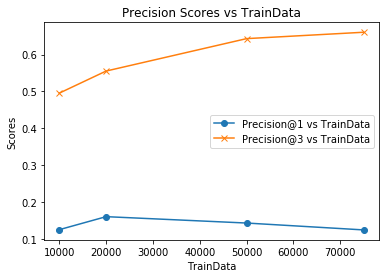

In [24]:
precisionVisualization()